### Load Data

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import glob
import ntpath
import time
from datetime import datetime
import time
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
%matplotlib inline

# helper function to extract the file name from any path
ntpath.basename("a/b/c")
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# get data files
path = "./Testing-Data/*.csv"
files_paths = glob.glob(path)
files = [path_leaf(x) for x in files_paths]

In [4]:
# read labels
df_labels = pd.read_csv("./Testing-Data/label/labels.csv")
df_labels = df_labels.set_index(['name'])

### Loop Over All Test Data Sets

sample anomaly inteval:
 [numpy.datetime64('2014-07-22T12:40:00.000000000'), numpy.datetime64('2014-07-17T12:15:00.000000000'), numpy.datetime64('2014-07-15T00:10:00.000000000'), numpy.datetime64('2014-07-07T22:55:00.000000000'), [numpy.datetime64('2014-07-17T13:05:00.000000000'), numpy.datetime64('2014-07-23T13:55:00.000000000')], [numpy.datetime64('2014-07-23T13:55:00.000000000'), numpy.datetime64('2014-07-11T17:15:00.000000000')], [numpy.datetime64('2014-07-11T17:15:00.000000000'), numpy.datetime64('2014-07-17T16:30:00.000000000')], numpy.datetime64('2014-07-09T22:50:00.000000000'), numpy.datetime64('2014-07-23T11:50:00.000000000'), numpy.datetime64('2014-07-24T13:30:00.000000000'), numpy.datetime64('2014-07-08T21:05:00.000000000'), numpy.datetime64('2014-07-23T14:45:00.000000000'), numpy.datetime64('2014-07-25T06:40:00.000000000')]


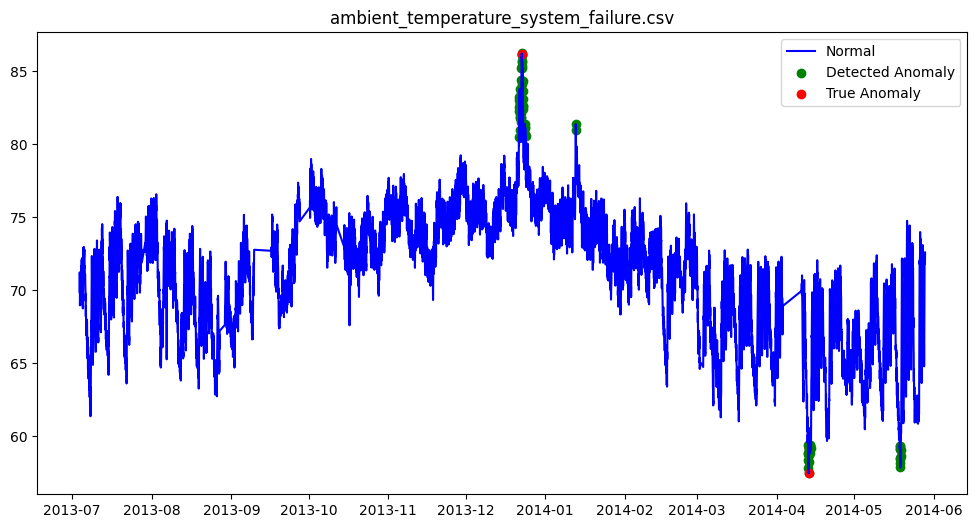

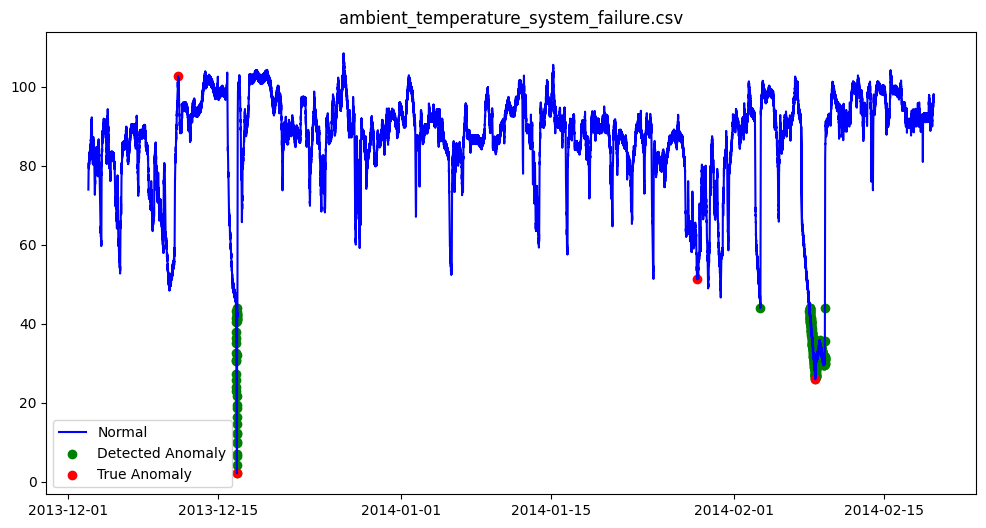

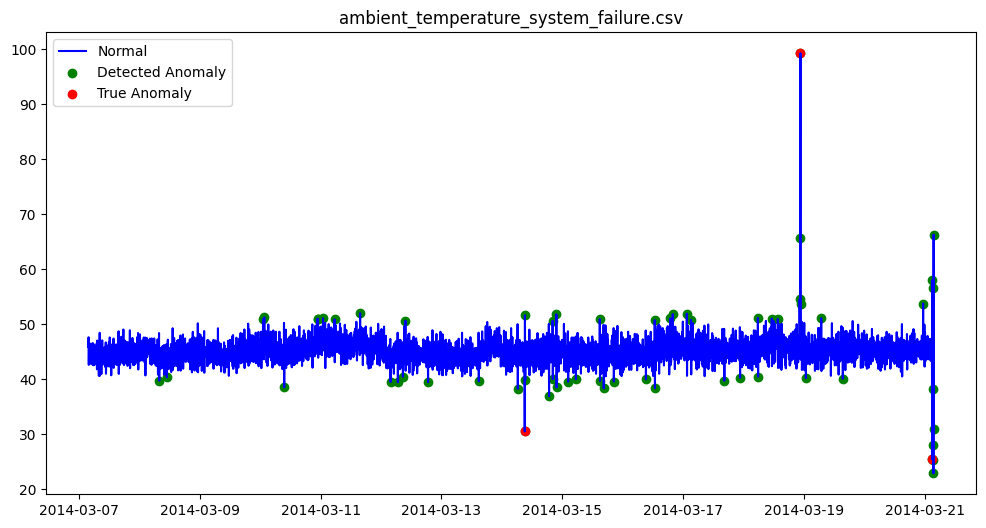

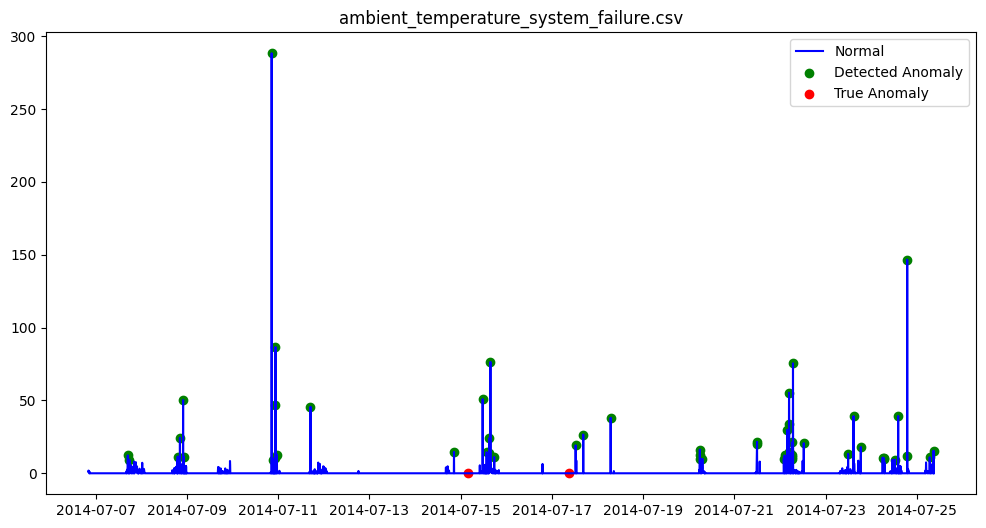

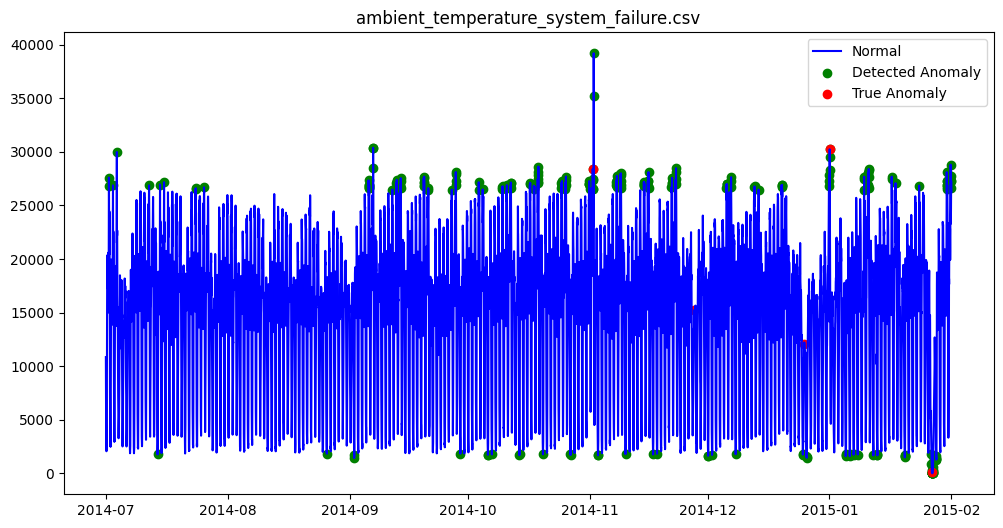

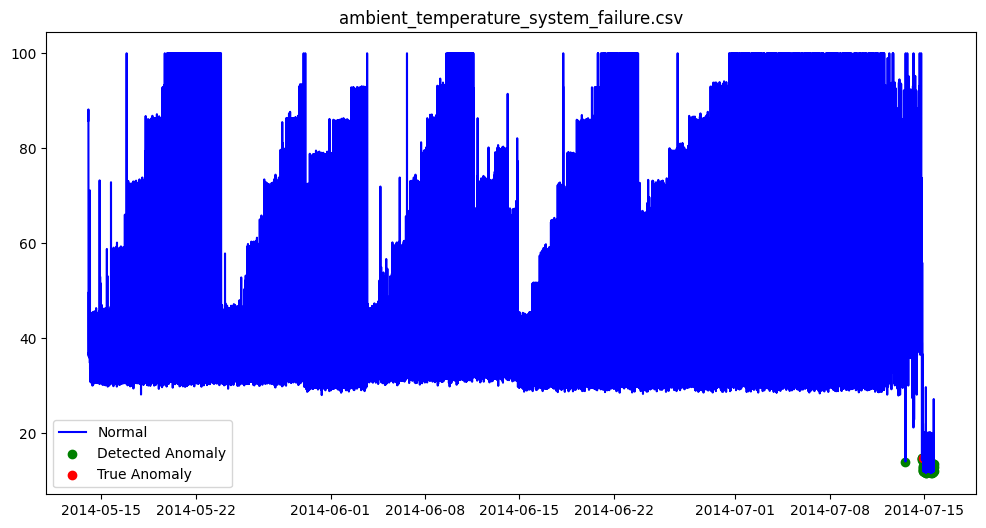

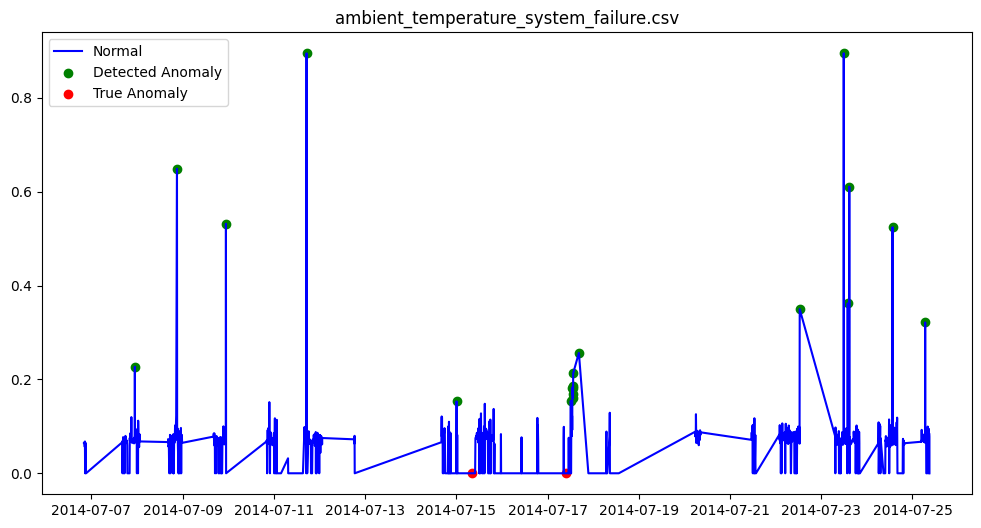

In [8]:
for i in range(len(files)):
    # preprocess labels to timedate objects
    def string_to_datetime(x):
        return datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')
    label = df_labels.loc[files[i]].values[0].split(',')
    label = np.array([string_to_datetime(x) for x in label])
    
    # read data
    df = pd.read_csv(files_paths[i])
    # preprocess 'time' to timedate objects
    df['time'] = pd.to_datetime(df['time'])

    # add anomaly labels to df
    def get_label(x):
        if x in label:
            return 1
        else:
            return 0
    df['label'] = df['time'].apply(get_label)

    # time as index
    df = df.set_index(['time'])
    
    # set outliers fraction
    outliers_fraction = 0.005*len(label)
    
    data = df['value'].values.reshape(-1, 1)
    # train isolation forest
    model =  IsolationForest(contamination=outliers_fraction)
    model.fit(data) 
    df['anomaly'] = pd.Series(model.predict(data)).values
    
    fig, ax = plt.subplots(figsize=(12,6))
    anomaly = df.loc[df['anomaly'] == -1, ['value']] #anomaly
    true_anomaly = df.loc[df['label'] == 1, ['value']] 
    ax.plot(df.index, df['value'], color='blue', label = 'Normal')
    ax.scatter(anomaly.index,anomaly['value'], color='green', label = 'Detected Anomaly')
    ax.scatter(true_anomaly.index, true_anomaly['value'], color='red', label = 'True Anomaly')
    plt.legend()
    plt.title(files[0])
    #plt.savefig('./Plots/' + files[i].split('.')[0] + '-IF-' + '.png')

    # get indices of anomalies
    a = df['anomaly'].values
    ind = np.where(a == -1)[0]

    # get the starting and ending points of anomaly intervals
    start = set(ind) - (set(ind) & set(ind+1))
    end = set(ind) - (set(ind) & set(ind-1))
    time = df.index.values

    # save intervals into a list
    anomaly_interval = []
    for s,e in zip(start, end):
        if s==e:
            anomaly_interval.append(time[s])
        else:
            anomaly_interval.append([time[s], time[e]])
            
    # output the intervals
print('sample anomaly inteval:\n',anomaly_interval)

### Demo For One Data Set

In [9]:
i = 0
# preprocess labels to timedate objects
def string_to_datetime(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')
label = df_labels.loc[files[i]].values[0].split(',')
label = np.array([string_to_datetime(x) for x in label])

In [10]:
# read data
df = pd.read_csv(files_paths[i])
# preprocess 'time' to timedate objects
df['time'] = pd.to_datetime(df['time'])

# add anomaly labels to df
def get_label(x):
    if x in label:
        return 1
    else:
        return 0
df['label'] = df['time'].apply(get_label)

# time as index
df = df.set_index(['time'])

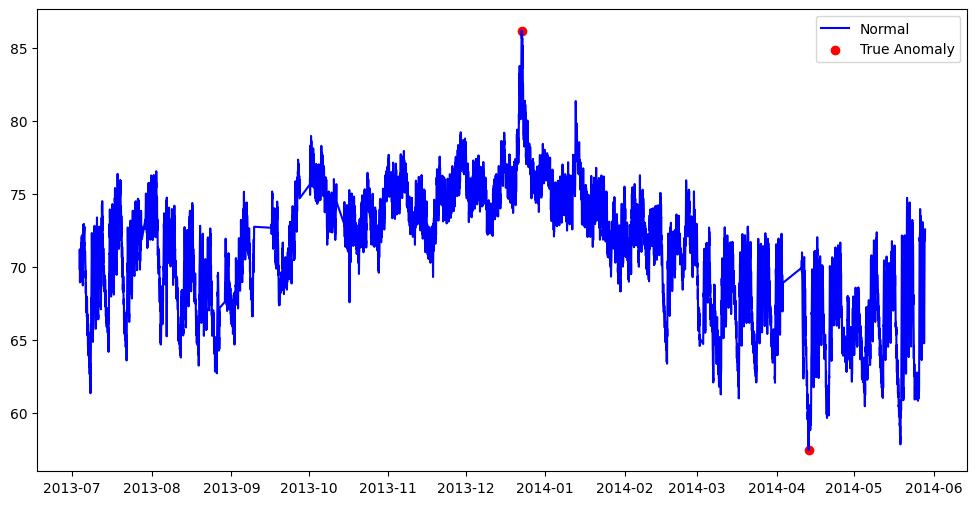

In [11]:
# visualization
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df.index, df['value'], color='blue', label = 'Normal')
ax.scatter(df[df['label']==1].index, df[df['label']==1]['value'], color='red', label = 'True Anomaly')
plt.legend()
plt.show()

In [12]:
# set outliers fraction
outliers_fraction = 0.005*len(label)

In [13]:
data = df['value'].values.reshape(-1, 1)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
df['anomaly'] = pd.Series(model.predict(data)).values

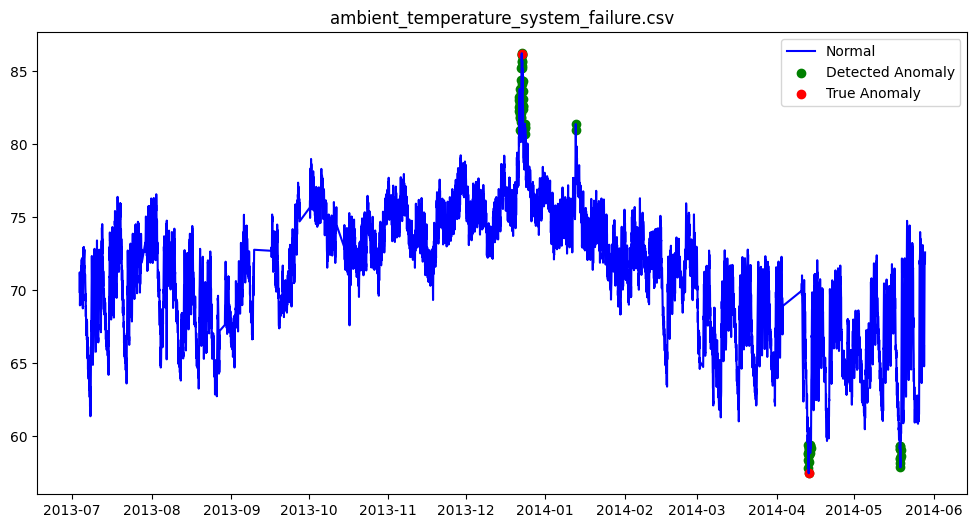

In [14]:
# visualization
fig, ax = plt.subplots(figsize=(12,6))
anomaly = df.loc[df['anomaly'] == -1, ['value']] #anomaly
true_anomaly = df.loc[df['label'] == 1, ['value']] 
ax.plot(df.index, df['value'], color='blue', label = 'Normal')
ax.scatter(anomaly.index,anomaly['value'], color='green', label = 'Detected Anomaly')
ax.scatter(true_anomaly.index, true_anomaly['value'], color='red', label = 'True Anomaly')
plt.legend()
plt.title(files[0])
# plt.savefig('./Plots/'+ 'IF-' + files[i].split('.')[0] + '.png')
plt.show()

In [15]:
# get indices of anomalies
a = df['anomaly'].values
ind = np.where(a == -1)[0]

# get the starting and ending points of anomaly intervals
start = set(ind) - (set(ind) & set(ind+1))
end = set(ind) - (set(ind) & set(ind-1))
time = df.index.values

# save intervals into a list
anomaly_interval = []
for s,e in zip(start, end):
    if s==e:
        anomaly_interval.append(time[s])
    else:
        anomaly_interval.append([time[s], time[e]])

In [16]:
# sample output the intervals
anomaly_interval[0]

[numpy.datetime64('2014-01-12T20:00:00.000000000'),
 numpy.datetime64('2013-12-22T11:00:00.000000000')]